## Train and Prediction on all data

Using rotated to hz + OpenCv border

Basic default transforms

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [61]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join
from fastai_extensions import *
from PIL import Image as pil_image

In [3]:
torch.cuda.set_device(2)
torch.cuda.current_device()

2

In [4]:
data_dir = Path('data')
data_04 = Path('data_04')

In [5]:
MODEL_NAME='bg_const'

In [6]:
NB_NUM='03_30'
tfm_name='mixup'

In [7]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: fb9c67aa, DATE: 20191201


In [8]:
#DATE = '20191201'
#UID = '880e78cc'

In [9]:
SUB_NUM='30'

In [10]:
img_size=256
bs=128
background='constant'

In [11]:
train_images=data_04/f'train/rotated/clipped/constant/{img_size}'
test_images=data_04/f'test/rotated/clipped/constant/{img_size}'

In [12]:
train_names = get_image_files(train_images)

In [13]:
test_names = get_image_files(test_images)

### using valid + gold preds instead of all

In [14]:

def roof_aug_split():
    df_gold = pd.read_csv(data_dir / 'df_all_repl_st_lucia_castries_gold_concrete_cement.csv')
    df_gold.drop(columns=['target'], inplace=True)
    df_gold = df_gold[['id', 'roof_material', 'verified', 'country', 'region']]

    df_pewter_70pct = pd.read_csv(data_dir / 'st_lucia_castries_gros_islet_70pct_rn50-rn152-dn121_preds.csv')
    df_pewter_70pct.tail()
    frames = [df_gold, df_pewter_70pct]
    df_gold_pewter = pd.concat(frames)

    #### test data
    df_test = pd.read_csv(data_dir / 'df_test_all.csv')
    gp_ids = df_gold_pewter.id.values.tolist()

    trn_file_names = []
    for f in train_names:
        trn_file_names.append(f.name.split('.tif')[0])

    bg_const_names = []
    for f in trn_file_names:
        if '_256_bgconstant' in f:
            bg_const_names.append(f.split('_256_bgconstant')[0])

    raw_names = []
    for f in trn_file_names:
        if '_raw' in f:
            raw_names.append(f.split('_raw')[0])

    zoom_names = []
    for f in trn_file_names:
        if '_zoom' in f:
            zoom_names.append(f.split('_zoom')[0])

    reflect_names = []
    for f in trn_file_names:
        if '_256_reflect' in f:
            reflect_names.append(f.split('_256_reflect')[0])

    wrap_names = []
    for f in trn_file_names:
        if '_256_wrap' in f:
            wrap_names.append(f.split('_256_wrap')[0])

    df_gold_pewter_bg_const = df_gold_pewter.loc[df_gold_pewter['id'].isin(bg_const_names)]
    df_gold_pewter_bg_const['id'] = df_gold_pewter_bg_const['id'] + '_256_bgconstant'
    df_gold_pewter_bg_const = df_gold_pewter_bg_const.drop_duplicates(subset=['id'])

    # Ensure is only ids with _256_bgconstant

    #### raw
    df_gold_pewter_raw = df_gold_pewter.loc[df_gold_pewter['id'].isin(raw_names)]
    df_gold_pewter_raw['id'] = df_gold_pewter_raw['id'] + '_raw'
    df_gold_pewter_raw = df_gold_pewter_raw.drop_duplicates(subset=['id'])

    #### zoom
    df_gold_pewter_zoom = df_gold_pewter.loc[df_gold_pewter['id'].isin(zoom_names)]
    df_gold_pewter_zoom['id'] = df_gold_pewter_zoom['id'] + '_zoom'
    df_gold_pewter_zoom = df_gold_pewter_zoom.drop_duplicates(subset=['id'])

    #### wrap
    df_gold_pewter_wrap = df_gold_pewter.loc[df_gold_pewter['id'].isin(wrap_names)]
    df_gold_pewter_wrap['id'] = df_gold_pewter_wrap['id'] + '_256_wrap'
    len(df_gold_pewter_wrap)
    df_gold_pewter_wrap = df_gold_pewter_wrap.drop_duplicates(subset=['id'])

    df_gold_pewter_reflect = df_gold_pewter.loc[df_gold_pewter['id'].isin(reflect_names)]
    df_gold_pewter_reflect['id'] = df_gold_pewter_reflect['id'] + '_256_reflect'
    df_gold_pewter_reflect = df_gold_pewter_reflect.drop_duplicates(subset=['id'])
    return df_gold_pewter_bg_const, df_gold_pewter_reflect, df_gold_pewter_wrap, df_gold_pewter_zoom, df_gold_pewter_raw

In [15]:
def get_train_val_test(roof_combinations):
    df_gold_pewter = pd.concat(roof_combinations)

    # ### split df manally
    df_val = df_gold_pewter.sample(frac=0.07)
    df_val_ids = df_val.id.values.tolist()

    core_ds = []
    for id in df_val_ids:
        core_ds.append(id.split('_')[0])

    core_ds = list(set(core_ds))
    df_val = df_gold_pewter[df_gold_pewter['id'].str.contains('|'.join(core_ds))]
    df_train = df_gold_pewter[~df_gold_pewter['id'].str.contains('|'.join(core_ds))]
    df_val['is_valid'] = True
    df_train['is_valid'] = False
    frames = [df_val, df_train]
    df_train = pd.concat(frames)
    return df_train, df_val

In [16]:
def get_transforms_cutout():
    cutout_1 = cutout(n_holes=(1, 4), length=(10, 20), p=.5)
    cutout_2 = cutout(n_holes=(1, 4), length=(10, 20), p=.5)
    cutout_3 = cutout(n_holes=(1, 4), length=(20, 20), p=.6)
    cutout_4 = cutout(n_holes=(1, 4), length=(20, 20), p=.6)
    xtra_tfms = [cutout_1, cutout_2, cutout_3, cutout_4, rand_crop(p=0.4), rand_zoom(scale=(1., 1.5), p=0.4)]
    tfms = get_transforms(flip_vert=True, max_lighting=0.25, max_warp=0., xtra_tfms=xtra_tfms)
    return tfms

In [17]:
def get_transforms_crop():
    xtra_tfms = [rand_crop(p=0.4), rand_zoom(scale=(1., 1.5), p=0.4)]
    tfms = get_transforms(flip_vert=True, max_lighting=0.25, max_warp=0., xtra_tfms=xtra_tfms)
    return tfms

### setup dataset

In [18]:
def setup_dataset(df_train, tfms):

    # ### setup dataset
    np.random.seed(42)
    dep_var = 'roof_material'
    src = (ImageList.from_df(path=train_images, df=df_train, cols='id', suffix='.tif')
           # .split_by_rand_pct(0.1)
           .split_from_df(col='is_valid')
           .label_from_df(cols=dep_var)
           .add_test_folder(test_images))

    data = (src.transform(tfms=tfms, size=img_size)
            .databunch(bs=bs).normalize(imagenet_stats))
    return data

In [19]:
df_gold_pewter_bg_const, df_gold_pewter_reflect, df_gold_pewter_wrap, df_gold_pewter_zoom, df_gold_pewter_raw = roof_aug_split()

/home/walle/miniconda3/envs/fastai-dev/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Experimenting with different data combos in 03_38 - also try all

In [20]:
#const_ref_wrap_zoom_combo = [df_gold_pewter_bg_const, df_gold_pewter_reflect, df_gold_pewter_wrap, df_gold_pewter_zoom]
roof_combinations = [df_gold_pewter_zoom, df_gold_pewter_raw]

In [21]:
df_train, df_val=get_train_val_test(roof_combinations)
data=setup_dataset(df_train, tfms=get_transforms_crop())

/home/walle/miniconda3/envs/fastai-dev/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/walle/miniconda3/envs/fastai-dev/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


24771


`show_batch` still works, and show us the different labels separated by `;`.

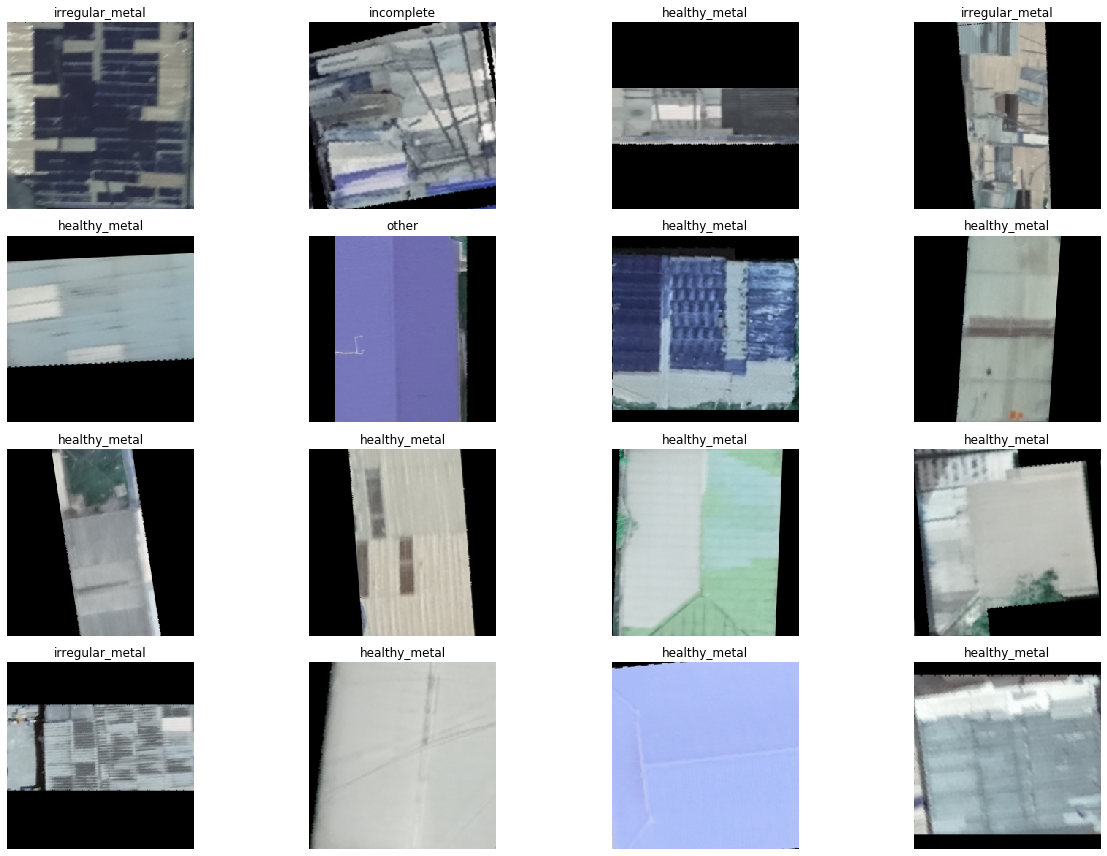

In [27]:
data.show_batch(rows=4, figsize=(18,12))

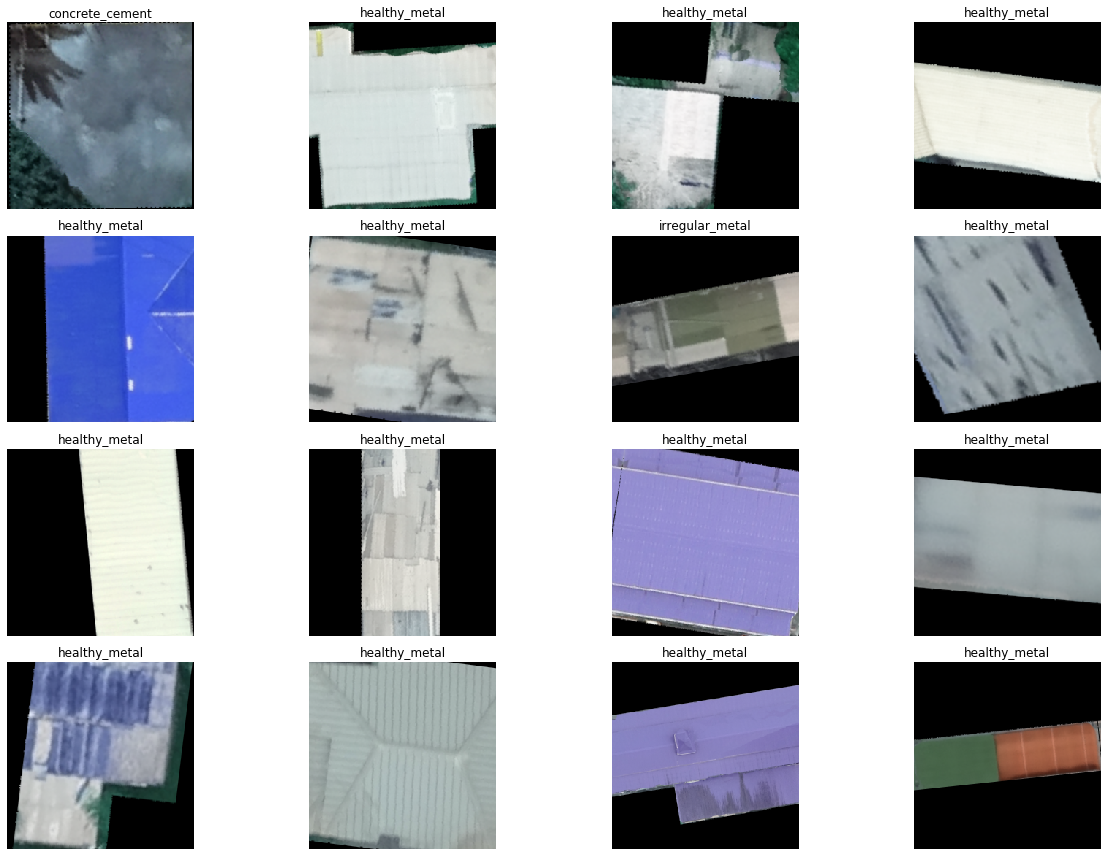

In [28]:
data.show_batch(rows=4, figsize=(18,12))

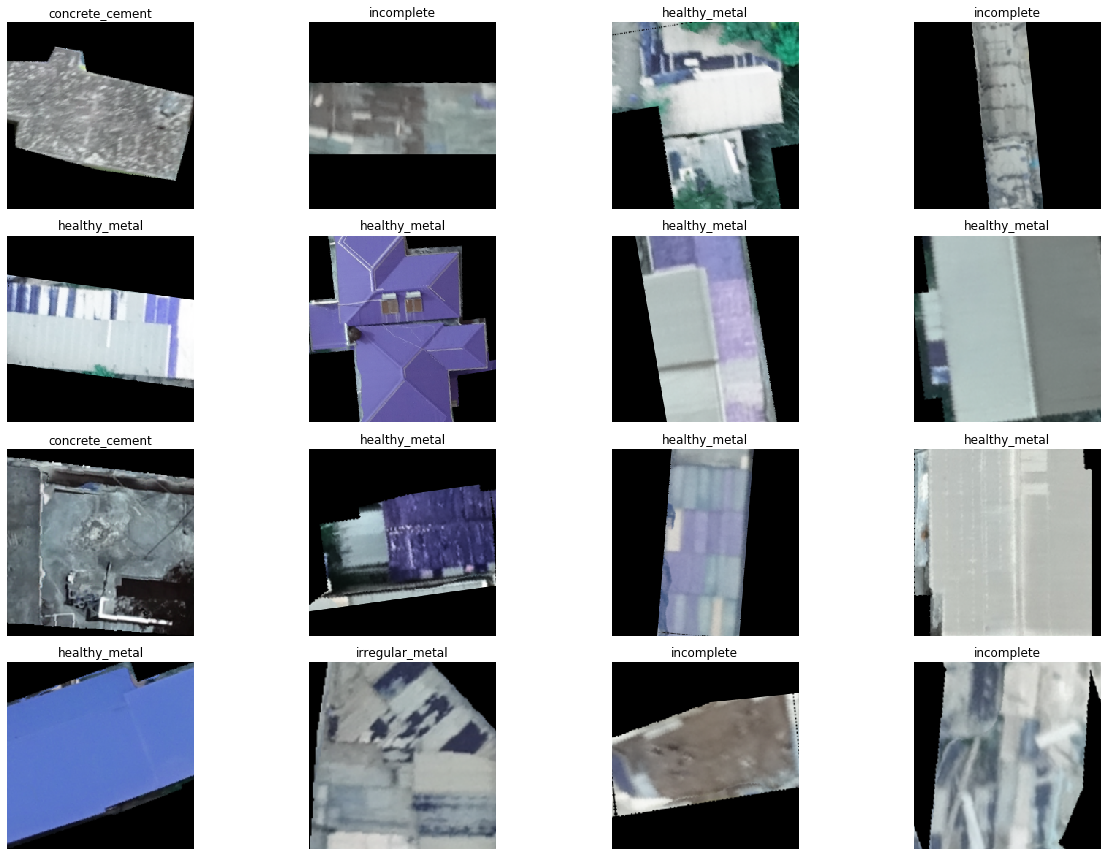

In [29]:
data.show_batch(rows=4, figsize=(18,12))

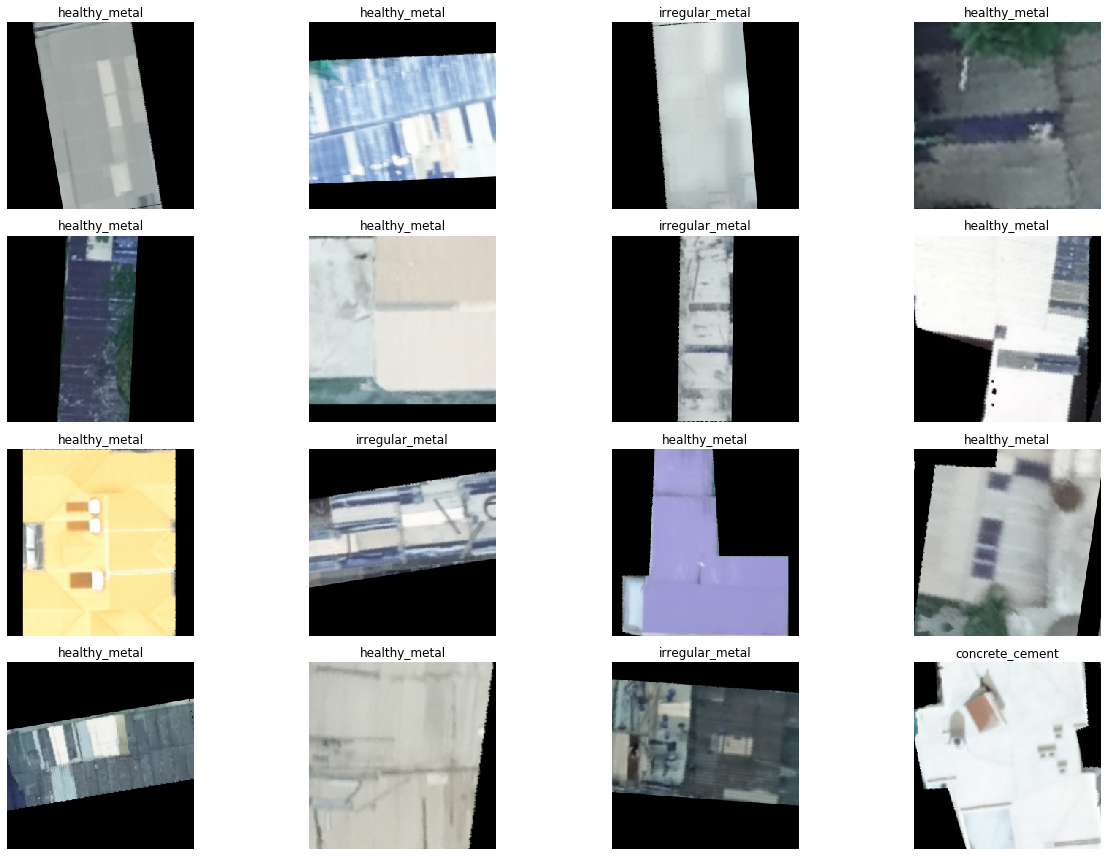

In [30]:
data.show_batch(rows=4, figsize=(18,12))

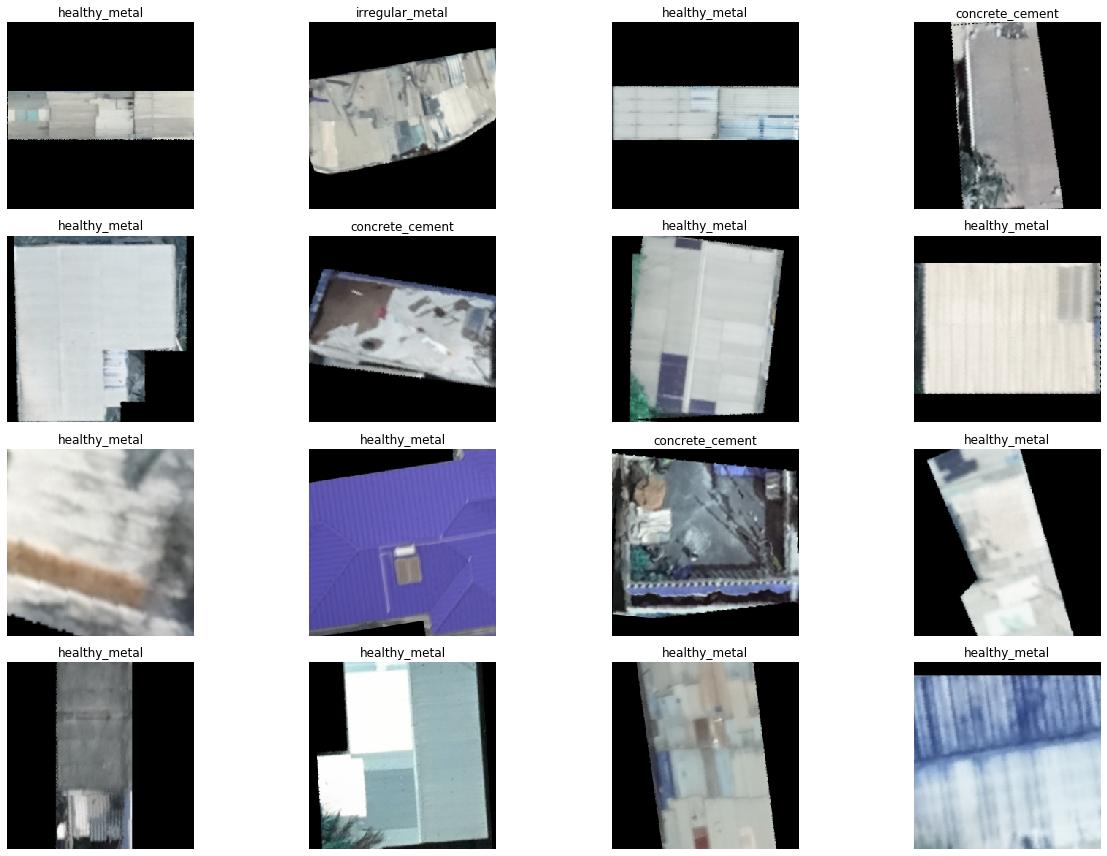

In [31]:
data.show_batch(rows=4, figsize=(18,12))

### Model

In [32]:
arch = models.resnet50
arch_name = 'rn50'

In [33]:
learn = cnn_learner(data, arch, metrics=error_rate, bn_final=True).to_fp16()
learn=learn.mixup()


We use the LR Finder to pick a good learning rate.

### Train model

In [34]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


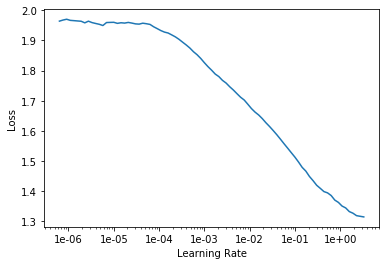

In [35]:
learn.recorder.plot()

Then we can fit the head of our network.

In [36]:
lr = 1e-2

In [37]:
learn.fit_one_cycle(5, slice(lr))

In [38]:
learn.save(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{tfm_name}-{DATE}-{UID}')

In [103]:
learn.load(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{tfm_name}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (22719 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,irregular_metal,irregular_metal,irregular_metal
Path: data_04/train/rotated/clipped/constant/256;

Valid: LabelList (2052 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,incomplete,incomplete,incomplete,healthy_metal
Path: data_04/train/rotated/clipped/constant/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data_04/train/rotated/clipped/constant/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, di

In [104]:
interp_1 = ClassificationInterpretation.from_learner(learn)
interp_1.most_confused(min_val=2)

[('irregular_metal', 'healthy_metal', 88),
 ('healthy_metal', 'irregular_metal', 48),
 ('incomplete', 'irregular_metal', 38),
 ('concrete_cement', 'healthy_metal', 16),
 ('incomplete', 'healthy_metal', 12),
 ('healthy_metal', 'concrete_cement', 11),
 ('incomplete', 'concrete_cement', 8),
 ('irregular_metal', 'concrete_cement', 8),
 ('other', 'healthy_metal', 8),
 ('concrete_cement', 'irregular_metal', 7),
 ('irregular_metal', 'incomplete', 6),
 ('irregular_metal', 'other', 4)]

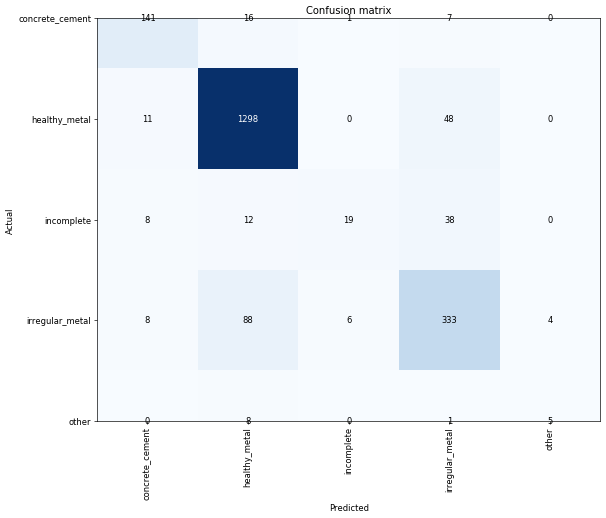

In [105]:
interp_1.plot_confusion_matrix(figsize=(10,10), dpi=60)

### Re-train

In [41]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


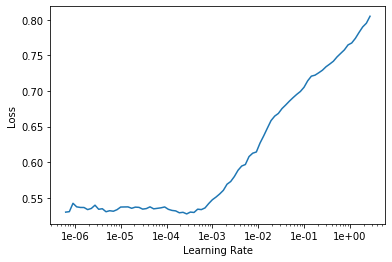

In [42]:
learn.lr_find()
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(5, slice(1e-6, lr/5))

In [44]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{tfm_name}-{DATE}-{UID}')

In [45]:
#learn.fit_one_cycle(5, slice(1e-6, lr/5))

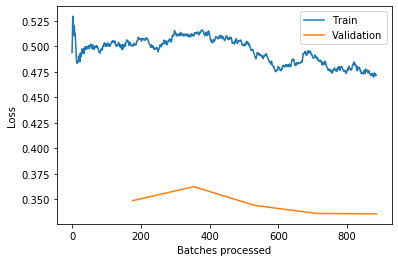

In [46]:
learn.recorder.plot_losses()

In [103]:
### QC

In [106]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{tfm_name}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (22719 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,irregular_metal,irregular_metal,irregular_metal
Path: data_04/train/rotated/clipped/constant/256;

Valid: LabelList (2052 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,incomplete,incomplete,incomplete,healthy_metal
Path: data_04/train/rotated/clipped/constant/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data_04/train/rotated/clipped/constant/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, di

In [107]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('irregular_metal', 'healthy_metal', 84),
 ('healthy_metal', 'irregular_metal', 45),
 ('incomplete', 'irregular_metal', 33),
 ('concrete_cement', 'healthy_metal', 16),
 ('concrete_cement', 'irregular_metal', 10),
 ('incomplete', 'healthy_metal', 10),
 ('healthy_metal', 'concrete_cement', 9),
 ('incomplete', 'concrete_cement', 9),
 ('irregular_metal', 'concrete_cement', 8),
 ('other', 'healthy_metal', 8),
 ('irregular_metal', 'incomplete', 7),
 ('irregular_metal', 'other', 4),
 ('healthy_metal', 'incomplete', 2),
 ('healthy_metal', 'other', 2)]

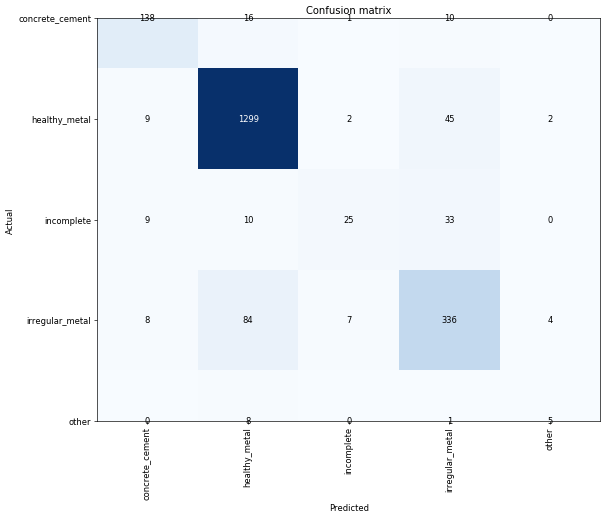

In [108]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

In [119]:
all_losses=interp.top_losses(len(interp.losses), largest=True)

In [122]:
len(all_losses[1])

2052

In [123]:
len(interp.losses)

2052

In [126]:
all_idx=all_losses[1].tolist()
all_loss=all_losses[0].tolist()

In [129]:
all_loss[1000]

0.07499418407678604

In [130]:
def index_valid(idxl):
    '''return loss name by order of top loss'''
    lossidx_img={}
    for c, i in enumerate(idxl):
        f=learn.data.valid_ds.items[i]
        lossidx_img[c]=f
    return lossidx_img

In [158]:
all_images=index_valid(all_idx)

In [159]:
def show_n_images(im_list):
    for iname in im_list:
        #plt.imshow(im, interpolation = 'bicubic')
        im = pil_image.open(iname)
        plt.imshow(im)
        plt.title(iname)
        plt.show()

In [160]:
all_images=list(all_images.values())

In [161]:
all_images[0]

'data_04/train/rotated/clipped/constant/256/7a3f2cd6_raw.tif'

In [167]:
def get_img_id(all_images):
    ids=[]
    for img_name in all_images: 
        end=img_name.split('/')[-1]
        ids.append(end.split('.tif')[0])
    return ids

In [168]:
ids=get_img_id(all_images)

In [170]:
assert len(ids)==len(all_loss)

In [171]:
# list of strings 
columns=['id','loss']
  
df = pd.DataFrame(list(zip(ids, all_loss)), 
               columns =columns) 

In [172]:
df.head()

id      loss
0   7a3f2cd6_raw  5.088663
1   7a2f21d8_raw  5.025627
2  7a3f2cd6_zoom  4.909372
3   7a3ffcf6_raw  4.844709
4   7a29a2a8_raw  4.682217

In [173]:
df['model']=f'{arch_name}-{NB_NUM}-{MODEL_NAME}-{tfm_name}-{DATE}-{UID}'

In [174]:
df.head()

id      loss                                        model
0   7a3f2cd6_raw  5.088663  rn50-03_30-bg_const-mixup-20191201-fb9c67aa
1   7a2f21d8_raw  5.025627  rn50-03_30-bg_const-mixup-20191201-fb9c67aa
2  7a3f2cd6_zoom  4.909372  rn50-03_30-bg_const-mixup-20191201-fb9c67aa
3   7a3ffcf6_raw  4.844709  rn50-03_30-bg_const-mixup-20191201-fb9c67aa
4   7a29a2a8_raw  4.682217  rn50-03_30-bg_const-mixup-20191201-fb9c67aa

In [124]:
#top20=[top_loss_images[x] for x in range(20)]
#top20

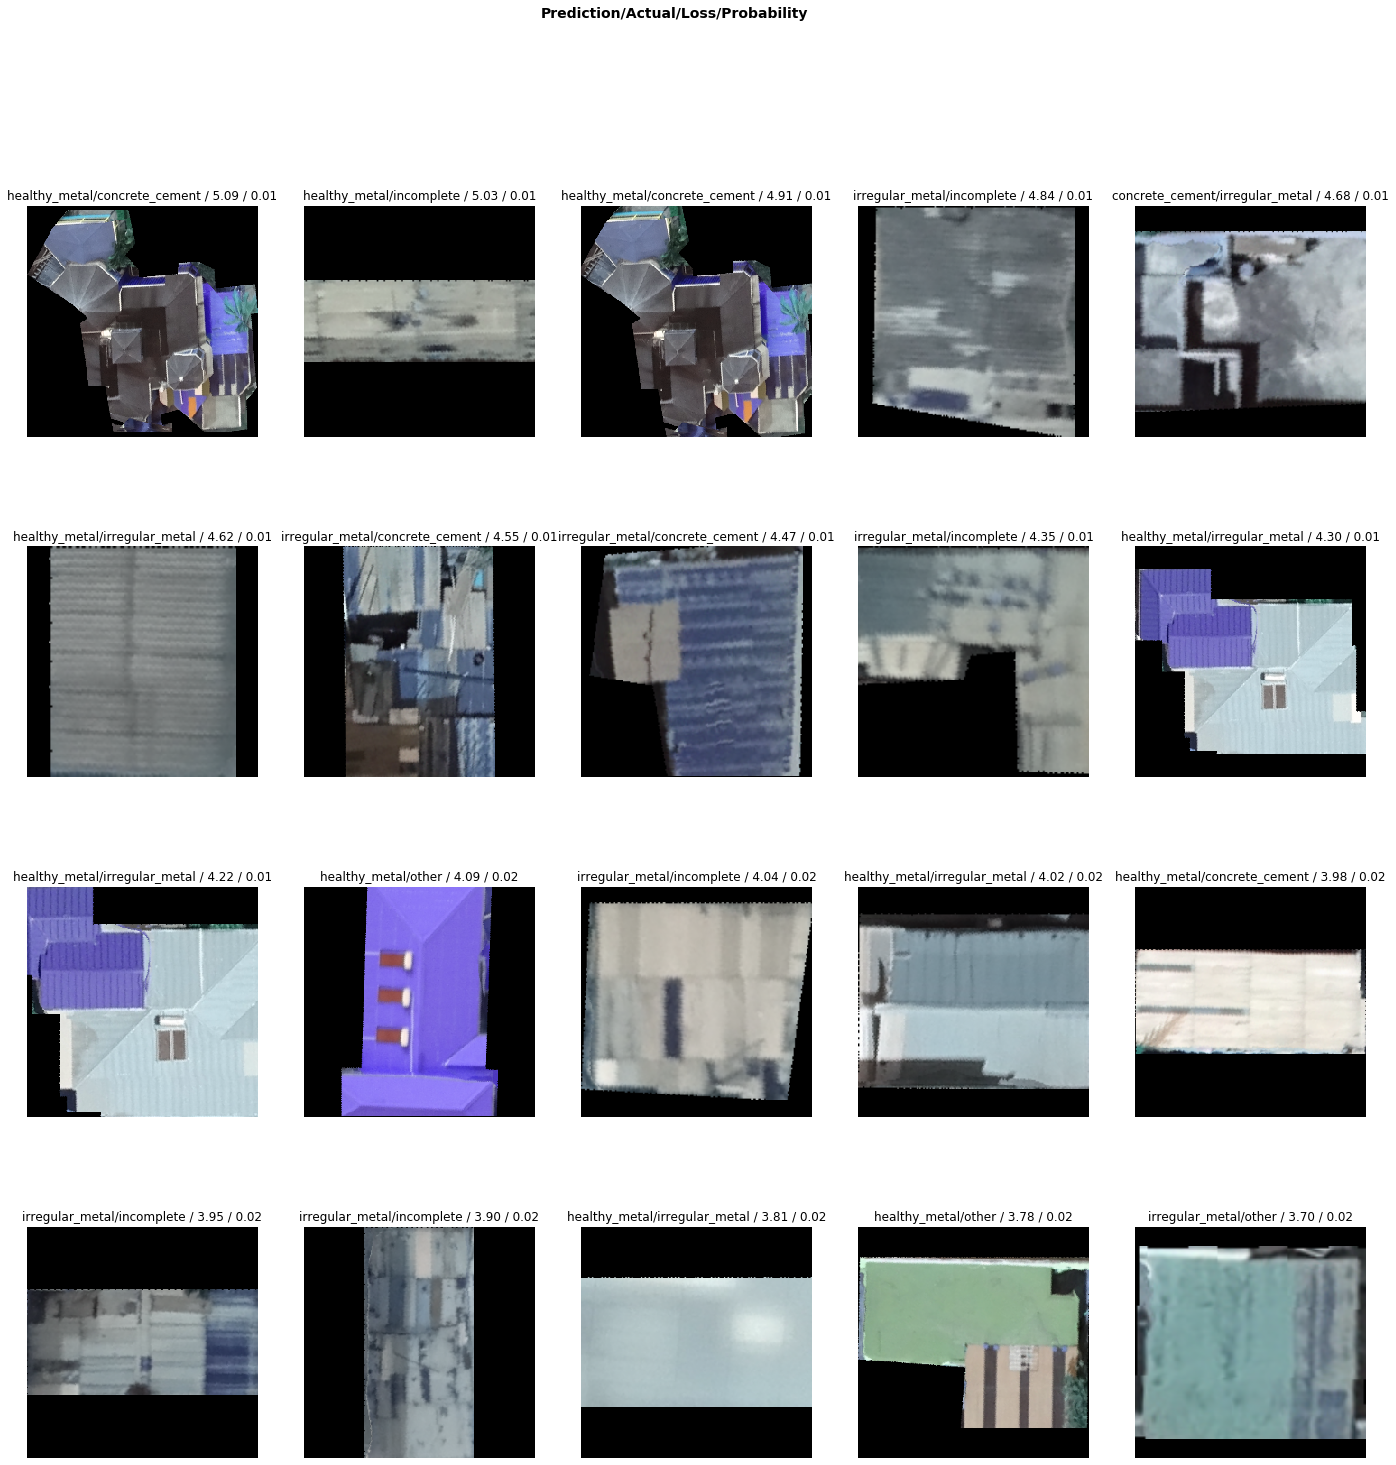

In [116]:
interp.plot_top_losses(k=20, largest=True, figsize=(24,24))